In [9]:
import torch
import torchvision
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [10]:
print("CUDA is available:", torch.cuda.is_available())
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

CUDA is available: True
PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


In [11]:
# import library which can handle video and extract frames
import cv2
import numpy as np
calibration_path = 'Videos/MVI_6478.MP4'
cap = cv2.VideoCapture(calibration_path)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()
frames = np.array(frames)
print(frames.shape)

(182, 1080, 1920, 3)


In [12]:
# Calibration 13.0643"

In [13]:

image = cv2.cvtColor(frames[0][:,:,:], cv2.COLOR_BGR2RGB)

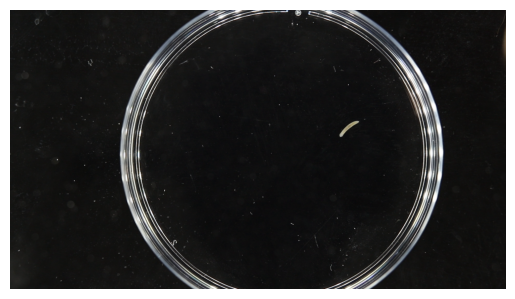

In [14]:
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
sam_checkpoint = "../Model/sam_vit_l_0b3195.pth"
model_type = "vit_l"

In [16]:
device = "cuda"

In [17]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device)

mask_generator_ = SamAutomaticMaskGenerator(model=sam, 
                                           points_per_side=32,
                                           pred_iou_thresh=0.9,
                                           stability_score_thresh=0.96,
                                           crop_n_layers=1,
                                           crop_n_points_downscale_factor=2,
                                           min_mask_region_area=100,
                                           )

In [18]:
masks = mask_generator_.generate(image)

In [19]:
def show_anns(anns):
    if len(anns) == 0:
        return
    #sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse = True)
    sorted_anns = anns
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for index, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m * 0.35)))
        # Add 'i' at the top right of the box
        x1, y1, w, h = ann['bbox']
        ax.text(x1+5*index, y1, str(index), fontsize=12, ha='left', color='yellow')
        

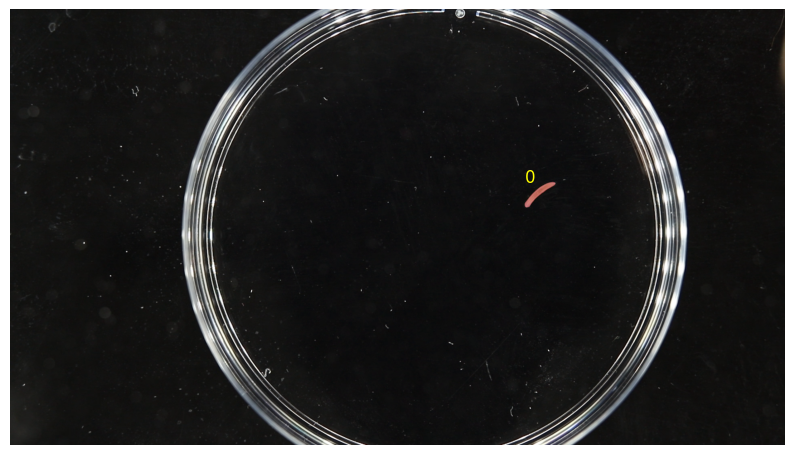

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_anns(masks[26:27])
plt.axis('off')
plt.show()

In [22]:
masks[26]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 1334,
 'bbox': [1275, 428, 76, 63],
 'predicted_iou': 0.9459178447723389,
 'point_coords': [[1290.0, 489.375]],
 'stability_score': 0.9696071147918701,
 'crop_box': [0, 0, 1920, 1080]}

In [39]:
from skimage.morphology import skeletonize, dilation, disk, thin, medial_axis
from skimage.measure import label
from scipy.ndimage import convolve

In [30]:
mask = np.ascontiguousarray(masks[26]['segmentation'])

In [31]:
mask.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [32]:
skeleton = skeletonize(mask)

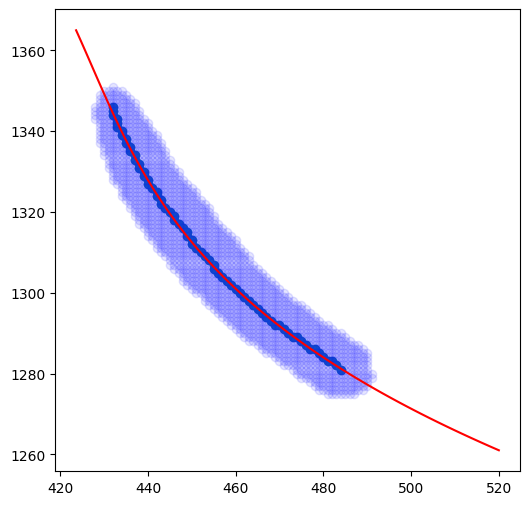

In [65]:
# Fit the dots in np.array(np.where(skeleton)) to a curve using a polynomial of degree 3
# The curve will be the centerline of the skeleton

# Get the coordinates of the skeleton
coords = np.array(np.where(skeleton))

# Fit the coordinates to a polynomial
p = np.poly1d(np.polyfit(coords[1], coords[0],3))

# Generate the x values for the polynomial
x = np.arange(coords[1].min()-20, coords[1].max()+20)

# Evaluate the polynomial to get the y values
y = p(x)

# Display the skeleton and the fitted curve
plt.figure(figsize=(6, 6))
plt.scatter(np.array(np.where(skeleton))[0], np.array(np.where(skeleton))[1])
plt.scatter(np.array(np.where(mask))[0], np.array(np.where(mask))[1],alpha=0.1,c='blue')
plt.plot(y,x, color='red')
plt.show()

In [70]:
# Calculate the length of the red curve if it is under the mask
length = 0
for i in range(len(x)-1):
    if mask[int(y[i]), int(x[i])]:
        length += math.sqrt((x[i+1]-x[i])**2 + (y[i+1]-y[i])**2)    

print(f"Length of the curve under the mask: {length/13.0643:.2f} mm")

Length of the curve under the mask: 7.42 mm


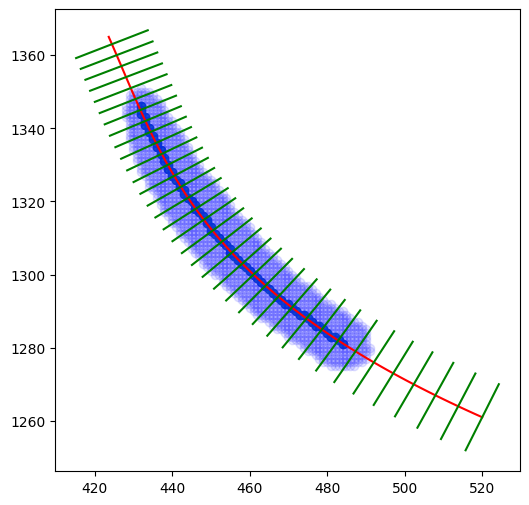

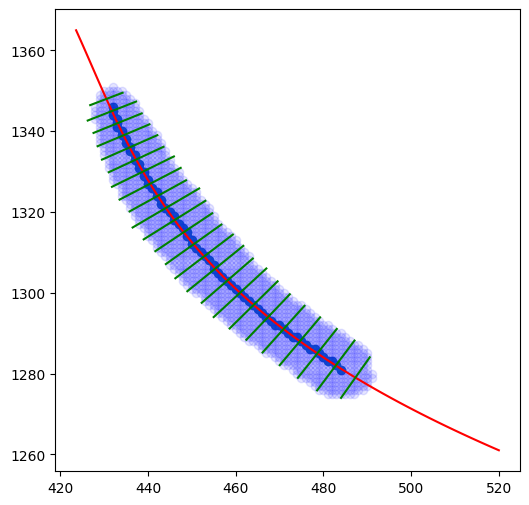

Average width of the mask: 1.30 mm


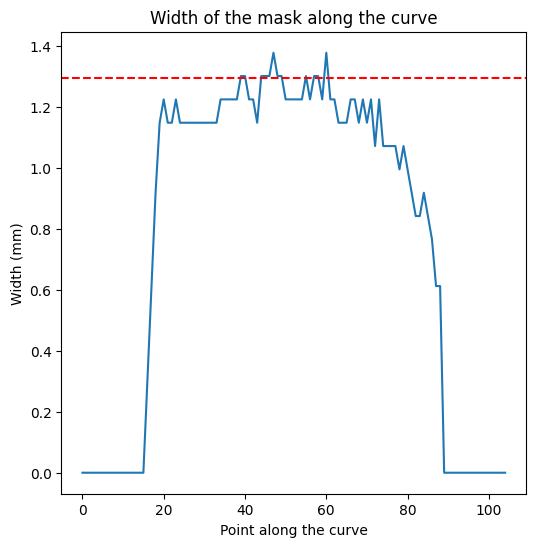

In [94]:
#  On each point of the curve, draw the normal line and find the intersection with the mask
#  Calculate the distance between the two points
#  Sum all the distances to get the total width of the mask

# Calculate the normal vector to the curve at each point
# The normal vector is the vector perpendicular to the tangent vector
# The tangent vector is the derivative of the curve
dy = np.gradient(y)
dx = np.gradient(x)
tangent = np.array([dy, dx]).T
tangent /= np.linalg.norm(tangent, axis=1)[:, None]
normal = np.array([-tangent[:, 1], tangent[:, 0]]).T

# Display the skeleton and the fitted curve
plt.figure(figsize=(6, 6))
plt.scatter(np.array(np.where(skeleton))[0], np.array(np.where(skeleton))[1])
plt.scatter(np.array(np.where(mask))[0], np.array(np.where(mask))[1],alpha=0.1,c='blue')
plt.plot(y,x, color='red')
for i in range(0,len(x),3):
    plt.plot([y[i]-normal[i,0]*10, y[i]+normal[i,0]*10], [x[i]-normal[i,1]*10, x[i]+normal[i,1]*10], color='green')
plt.show()

# Calculate the width of the mask at each point of the curve
widths = []
for i in range(len(x)):
    # Get the normal vector
    n = normal[i]
    # Get the point on the curve
    p = np.array([y[i], x[i]])
    # Initialize the width
    width = 0
    # Move along the normal vector until the mask is reached
    while mask[int(p[0]), int(p[1])]:
        p += n
        width += 1
    # Move along the normal vector in the opposite direction until the mask is reached
    p = np.array([y[i], x[i]])
    while mask[int(p[0]), int(p[1])]:
        p -= n
        width += 1
    widths.append(width)
    

# Display the skeleton and the fitted curve
plt.figure(figsize=(6, 6))
plt.scatter(np.array(np.where(skeleton))[0], np.array(np.where(skeleton))[1])
plt.scatter(np.array(np.where(mask))[0], np.array(np.where(mask))[1],alpha=0.1,c='blue')
plt.plot(y,x, color='red')
for i in range(0,len(x),3):
    plt.plot([y[i]-normal[i,0]*widths[i]/2, y[i]+normal[i,0]*widths[i]/2], [x[i]-normal[i,1]*widths[i]/2, x[i]+normal[i,1]*widths[i]/2], color='green')
plt.show()

# Calculate the numerical value of the width at each point
widths = np.array(widths)/13.0643

# Calculate the average width
average_width = np.mean(np.sort(widths)[::-1][:15])
print(f"Average width of the mask: {average_width:.2f} mm")

# Plot how width changes along the curve
plt.figure(figsize=(6, 6))
plt.plot(widths)

# Draw a horizontal line at the average width
plt.axhline(y=average_width, color='r', linestyle='--')
plt.xlabel('Point along the curve')
plt.ylabel('Width (mm)')
plt.title('Width of the mask along the curve')
plt.show()



In [87]:
np.sort(widths)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3061779 , 0.61235581, 0.61235581,
       0.61235581, 0.76544476, 0.84198924, 0.84198924, 0.84198924,
       0.91853371, 0.91853371, 0.91853371, 0.99507819, 0.99507819,
       1.07162267, 1.07162267, 1.07162267, 1.07162267, 1.07162267,
       1.07162267, 1.14816714, 1.14816714, 1.14816714, 1.14816714,
       1.14816714, 1.14816714, 1.14816714, 1.14816714, 1.14816714,
       1.14816714, 1.14816714, 1.14816714, 1.14816714, 1.14816714,
       1.14816714, 1.14816714, 1.14816714, 1.14816714, 1.14816714,
       1.22471162, 1.22471162, 1.22471162, 1.22471162, 1.22471

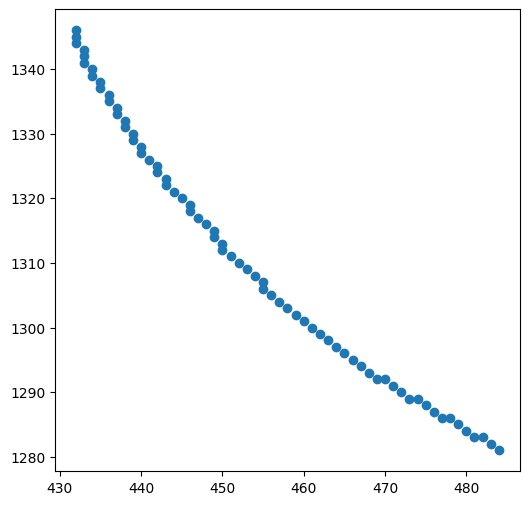

In [51]:
plt.figure(figsize=(6, 6))
plt.scatter(np.array(np.where(skeleton))[0], np.array(np.where(skeleton))[1])
plt.show()

In [42]:
70/13.0643

5.358113331751414